# This is me trying to learn linear (and multiple linear) regression algorithm by implementing them from scratch. Effectively just numpy and matrix calculus.

##### Importing the necessary libraries. The sklearn is need for cross-checking my code and for feature scaling.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing

## The training Data

In [3]:
df = pd.read_csv("CarPrice_Assignment.csv")
df["mpgcombined"] = df["citympg"] + df["highwaympg"]
df

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price,mpgcombined
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0,48
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0,48
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0,45
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0,54
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,201,-1,volvo 145e (sw),gas,std,four,sedan,rwd,front,109.1,...,mpfi,3.78,3.15,9.5,114,5400,23,28,16845.0,51
201,202,-1,volvo 144ea,gas,turbo,four,sedan,rwd,front,109.1,...,mpfi,3.78,3.15,8.7,160,5300,19,25,19045.0,44
202,203,-1,volvo 244dl,gas,std,four,sedan,rwd,front,109.1,...,mpfi,3.58,2.87,8.8,134,5500,18,23,21485.0,41
203,204,-1,volvo 246,diesel,turbo,four,sedan,rwd,front,109.1,...,idi,3.01,3.40,23.0,106,4800,26,27,22470.0,53


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

# Univariate Linear Regression

### Analytic Approach (without vectorization)

This is the cost function to be minimized
$$ J(w,b) = \frac{1}{2m}\sum_{i=0}^{m-1}(wx_{(i)}+b-y_{(i)}) $$ 

Since the cost function is convex, the stationary point will most definitely be critical point. Therefore, to minimize the it, we find the $w$ and $b$ such that $\nabla J(w,b)=0$. 

$$\frac{\partial J(w,b)}{\partial w} = \frac{1}{m}\sum_{i=0}^{m-1}(wx_{(i)}^{2}+bx_{(i)}-x_{(i)}y_{(i)}) = 0$$


$$\frac{\partial J(w,b)}{\partial b} = \frac{1}{m}\sum_{i=0}^{m-1}(x_{(i)}+b-y_{(i)}) = 0 $$

These results produce two linear equations with two unknowns

$$w\sum_{i=0}^{m-1}x_{(i)}^{2}+\sum_{i=0}^{m-1}bx_{(i)} = \sum_{i=0}^{m-1}x_{(i)}y_{(i)} $$
$$w\sum_{i=0}^{m-1}x_{(i)}+bm = \sum_{i=0}^{m-1}y_{(i)} $$

Solving, preferably using matrices, for w gives

$$w = \frac{m\sum_{i=0}^{m-1}x_{(i)}y_{(i)} - \sum_{i=0}^{m-1}x_{(i)}\sum_{i=0}^{m-1}y_{(i)}}{m\sum_{i=0}^{m-1}x_{(i)}^{2} - (\sum_{i=0}^{m-1}x_{(i)})^{2}}$$

Solving, in terms of w, for b gives

$$b = \bar{y} - w\bar{x}$$

In [3]:
# Creating a simple linear regression object
class uni_an_regression():
    # Defining the attribute to be the resulting parameter
    def __init__ (self, feature, target):
        m = len(target)
        sigma_x = feature.sum()
        sigma_y = target.sum()
        sigma_xy = (feature * target).sum()
        sigma_x_sqr = (feature**2).sum()
        w = (m*sigma_xy - sigma_x*sigma_y)/(m*sigma_x_sqr - sigma_x**2)
        b = target.mean() - w*feature.mean()
        self.w = w
        self.b = b
        
    # Defining function for predicting based on the parameter
    def predict(self, data):
        return self.w*data + self.b

### Numerical Approach (Gradient Descent)

The cost function decreases the most to the direction of the vector  $\nabla J(w,b)$.

Gradient Descent will find the most efficient baby-step to the global minimum. This is guaranteed to succeed due to the convex nature of the cost function.

The Algorithm:

$$\begin{align*} \text{repeat}&\text{ until the cost function converges:} \; \lbrace \newline
\;  w &= w -  \alpha \frac{\partial J(w,b)}{\partial w} \tag{3} = w - \alpha\frac{1}{m}\sum_{i=0}^{m-1}(wx_{(i)}^{2}+bx_{(i)}-x_{(i)}y_{(i)})  \; \newline 
 b &= b -  \alpha \frac{\partial J(w,b)}{\partial b} = b - \alpha\frac{1}{m}\sum_{i=0}^{m-1}(x_{(i)}+b-y_{(i)}) \newline \rbrace
\end{align*}$$
where w,b are updated simultaneously

In [12]:
# Computing the cost function
def cost_function(w, b, feature, target):
    return (1/(2*len(target)))*(((feature*w + b - target)**2).sum())

# Computing the update for the w parameter
def update_w(w, b, feature, target, alpha_w):
    return w - (alpha_w*(1/len(feature)) * (feature*(feature*w + b - target)).sum())

# Computing the update for the b parameter
def update_b(w, b, feature, target, alpha_b):
    return b - (alpha_b*(1/len(feature)) * ((w*feature + b - target)).sum())

# Combining everything to main gradient descent function
def gradient_descent(feature, target, iterations, w=0, b=0, alpha_w=0.0001, alpha_b=0.0001):
    cost = []
    for i in range(iterations):
        w, b = update_w(w, b, feature, target, alpha_w), update_b(w, b, feature, target, alpha_b) 
        # w and b should be updated simultaneously. Otherwise, the input for update_b will not be same as that of w.
        cost.append(cost_function(w, b, feature, target))
    return w, b

#### Experimenting on convergence

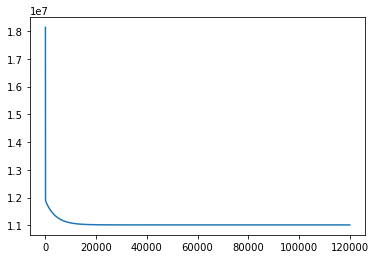

In [34]:
plt.plot(range(120000), df_cost_1)
plt.show()

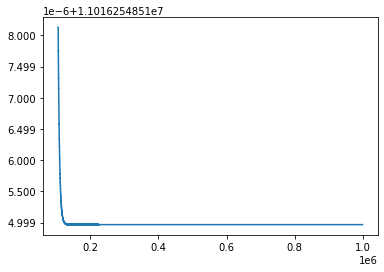

In [24]:
df_cost = np.array(df_cost)

plt.plot(range(105000, 1000000), df_cost[105000:])
plt.show()

It appears that because the feature and target are very different in terms of scaling, the gradient descent converges very slowly. Therefore, i might need to do feature scaling

### Non-scaled feature and target

In [6]:
%%time
gradient_descent(df["horsepower"].values, df["price"].values, 120000, alpha_w=0.0001, alpha_b=0.001)

CPU times: total: 9.41 s
Wall time: 9.46 s


(163.26305188012182, -3721.7604122071602)

In [6]:
%%time
reg_def = LinearRegression().fit(df["horsepower"].values.reshape(-1,1), df["price"].values.reshape(-1,1))
print(reg_def.coef_)
print(reg_def.intercept_)

[[163.26306097]]
[-3721.76149432]
CPU times: total: 125 ms
Wall time: 704 ms


### Scaled feature and target

In [8]:
min_max_scaler_hp = preprocessing.MinMaxScaler(feature_range =(0, 1))
min_max_scaler_price = preprocessing.MinMaxScaler(feature_range =(0, 1))

In [9]:
fet = min_max_scaler_hp.fit_transform(df["horsepower"].values.reshape(-1,1))
tar = min_max_scaler_price.fit_transform(df["price"].values.reshape(-1,1))

In [73]:
reg_scaled = LinearRegression().fit(fet, tar)
print(reg_scaled.coef_)
print(reg_scaled.intercept_)

[[0.97272068]]
[-0.0249028]


In [22]:
%%time
gradient_descent(fet, tar, 10000, alpha_w=0.5, alpha_b=0.1)

CPU times: total: 734 ms
Wall time: 771 ms


(0.9727206849817573, -0.02490279945664025)

In [22]:
%%time
gradient_descent(fet, tar, 1000, alpha_w=0.9, alpha_b=0.9)

CPU times: total: 93.8 ms
Wall time: 82.5 ms


(0.9727206849177784, -0.02490279944128791)

With the scaled feature, the execution of the algorithm is a lot faster.

To predict, just reverse the scaling, and the outcome will be the same.

# Multiple Linear Regression 

### Analytic Closed Form Solution

The model is $ \hat{y} = Xw$ where X is an $n \times (feature+1)$ matrix and w is a $(feature+1) \times 1$ matrix. It is $(feature+1)$ because the constant $b$ is incorporated into $w$, which means the first column of $X$ consists of only ones.


The cost function to be minimized is $ J(\vec{w}) = \frac{1}{2n}(X\vec{w} - \vec{y})^{T}(X\vec{w} - \vec{y}) $, the output of which is a $(feature+1) \times 1$ matrix. To minimized it, we set the $ \frac{\partial{J(\vec{w})}}{\partial{\vec{w}}} = 0 $ or $\nabla{J(\vec{w})}=0$. Since this function produces a scalar, its partial derivative with respect to vector $\vec{w}$ will have the same dimension as that of $\vec{w}$.

$$ J(\vec{w}) = \frac{1}{2n}(X\vec{w} - \vec{y})^{T}(X\vec{w} - \vec{y}) = \frac{1}{2n}(\vec{w}^{T}X^{T}X\vec{w} - \vec{w}^{T}X^{T}\vec{y} - \vec{y}^{T}X\vec{w} + \vec{y}^{T}\vec{y}) $$

$$ \frac{\partial{J(\vec{w})}}{\partial{\vec{w}}} = \frac{1}{2n}(2X^{T}X\vec{w} - 2X^{T}\vec{y}) = \frac{1}{n}X^{T}(X\vec{w} - \vec{y}) $$

Optimize it to solve for  $\vec{w}$

$$ \frac{1}{2n}(2X^{T}X\vec{w} - 2X^{T}\vec{y})=0$$

$$ \vec{w} = (X^{T}X)^{-1} X^{T}\vec{y}  $$


In [4]:
def analytic_multireg(feature, target):
    # feature: n x d numpy array 
    # target: n x 1 numpy array 
    X = np.hstack((np.array([1]*len(target)).reshape(-1,1), feature))
    X_trans = np.transpose(X)
    XX_trans = np.matmul(X_trans, X)
    inv = np.linalg.inv(XX_trans)
    X_transY = np.matmul(X_trans, target)
    return np.matmul(inv, X_transY)

In [8]:
%%time
analytic_multireg(df[["horsepower", "enginesize"]].values, df["price"].values.reshape(-1,1))

CPU times: total: 0 ns
Wall time: 2.98 ms


array([[-8389.73308932],
       [   58.84742172],
       [  122.44701649]])

### Gradient Descent Numerical Solution ( for loop approach)

In [215]:
class GdMultipleLinearRegression():
    
    def dj_dw(self, X, y, diff, n, m):
        result = 0
        for i in range(n):
            result += diff[i] * X[i]  # the X indexing convert to array to 1d (deletes any (,1) in it)
        return (result/n).reshape(-1,1)

    def dj_db(self, X, y, diff, n):
        return 1/n * (diff.sum())

    def err(self, X, y, w, b):
        return np.matmul(X, w) + b - y
    
    def predict(self, data, w, b):
        return np.matmul(data, w) + b
        
    def compute_cost(self, X, y, w, b, n):
        expression = np.matmul(X, w) + b - y
        return (1/(2*n))*(expression*expression).sum()
    
    def fit(self, X, y, iterations, alpha):
        n, m = X.shape
        w = np.zeros((m,1))
        b = 0
        cost = []

        for i in range(iterations):
            diff = self.err(X, y, w, b)
            w = w - alpha*self.dj_dw(X, y, diff, n , m)
            b = b - alpha*self.dj_db(X, y, diff, n)
            cost.append(self.compute_cost(X, y, w, b, n))
        self.w_final = w
        self.b_final = b
        self.cost_process = np.array(cost)

### Here comes the testing

In [223]:
reg_scikit = LinearRegression()
reg_scikit.fit(df[["horsepower", "enginesize"]].values, df["price"].values.reshape(-1,1))
print(reg_scikit.coef_)
print(reg_scikit.intercept_)

[[ 58.84742172 122.44701649]]
[-8389.73308932]


In [225]:
reg_scikit.coef_.shape

(1, 2)

In [12]:
from sklearn import preprocessing
min_max_scaler_price = preprocessing.MinMaxScaler(feature_range =(0, 1))
min_max_scaler_hp_enginesize = preprocessing.MinMaxScaler(feature_range =(0, 1))

tar = min_max_scaler_price.fit_transform(df["price"].values.reshape(-1, 1))
feat = min_max_scaler_hp_enginesize.fit_transform(df[["horsepower", "enginesize"]].values)

reg = LinearRegression().fit(feat, tar)
print(reg.coef_)
print(reg.intercept_)

[[0.35061271 0.80553248]]
[-0.07978226]


In [106]:
%%time
gradient_descent(feat, tar, 0.5, 0.5, 6000)

CPU times: total: 36.2 s
Wall time: 40 s


(array([0.35061281, 0.80553238]), -0.07978225309905451)

In [219]:
reg = GdMultipleLinearRegression()
reg.fit(feat, tar, 1000, 1)

In [220]:
reg.w_final

array([[0.35237921],
       [0.80365643]])

In [221]:
reg.b_final

-0.07972845001060065

## The most efficient approach so far. This involves combining the parameter into a column vector and inserting column of ones to the left of feature data.

$$\begin{align*} \text{repeat}&\text{ until the cost function converges:} \; \lbrace \newline
\;  \vec{w} &= \vec{w} -  \alpha \frac{\partial J(\vec{w})}{\partial \vec{w}} \tag{3} = \vec{w} - \alpha\frac{1}{n}(X^{T}X\vec{w} - X^{T}\vec{y}) =  \newline \rbrace
\end{align*}$$

there's only one parameter to update, since the coefficient and intercept was combined into one vector $\vec{w}$ 

In [48]:
class GdLinearRegression:
    
    def update_parameter (self, feature_n, target, parameter_n):
        total = np.transpose(feature_n) @ feature_n @ parameter_n - np.transpose(feature_n) @ target
        return total/len(target)
    
    def predict (self, data):
        return np.matmul(data, self.parameter_final)
    
    def compute_cost(self, parameter, X, target, n):
        terms = np.transpose(X@parameter - target) @ (X@parameter - target)
        return ((1/(2*n))*terms)[0][0] 

    def fit(self, feature, target, alpha, iterations):
        n, m = feature.shape
        X_filled = np.insert(feature, 0, np.array([1]*n), axis=1)
        parameter = np.zeros((m+1, 1))
        cost = []
        for i in range(iterations):
            parameter = parameter - alpha*self.update_parameter(X_filled, target, parameter)
            cost.append(self.compute_cost(parameter, X_filled, target, n))
        
        self.cost_process = np.array(cost)
        self.parameter_final = parameter
        self.w_final = parameter[0]
        self.b_final = parameter[1:]

### Testing

In [17]:
gradient_descent_once(df["horsepower"].values.reshape(-1,1), df["price"].values.reshape(-1,1), 0.0001, 1000000)

array([[-3721.74832425],
       [  163.26295035]])

In [49]:
reg = GdLinearRegression()
reg.fit(feat, tar, 0.9, 1000)

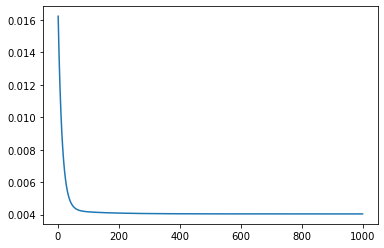

In [50]:
a = reg.cost_process
plt.plot(range(1, 1001), a)
plt.show()

## (Multiple) Linear Regression by Stochastic Gradient Descent

In this approach, the gradient is determined, not by summing the entire feature data, but by the sample (batch) or only one feature that was acquired through random sampling. One reason it works is due the fact that the expected value of "partial" gradient is equal to the "full" gradient 
$$\mathbf{E}(SGD\,gradient) = True\,Gradient$$

This should reduce the number of computations performed by the algorithm

In [162]:
class SGDReg:
    
    def update_parameter(self, feature_n, target, parameter_n):
        total = np.transpose(feature_n) @ feature_n @ parameter_n - np.transpose(feature_n) @ target
#         print(total.shape)
        return total/len(target)
    
    def fit(self, feature, target, alpha, iterations, batch_size):
        n,m = feature.shape
        feat_tar = np.hstack((feature, target))
        X_filled = np.insert(feat_tar, 0, np.array([1]*n), axis=1)
        parameter = np.random.randint(1,m+2, size=(m+1, 1))
        
        for i in range(iterations):
            chosen_row = np.random.choice(np.arange(0, n), size=(batch_size))
            chosen_feat = X_filled[chosen_row, :-1]
            target = X_filled[chosen_row, -1].reshape(-1, 1)
            parameter = parameter - alpha * self.update_parameter(chosen_feat, target, parameter)
#             print(parameter)
        
        self.parameter_final = parameter

        

### Testing

In [168]:
reg = SGDReg()
reg.fit(feat, tar, 0.3, 10000, 20)
print(reg.parameter_final)

[[-0.07902753]
 [ 0.35615819]
 [ 0.79756766]]


In [ ]:
[[0.35061271 0.80553248]]
[-0.07978226]

### Not a bad start for me :P